# Normalization Comparison Analysis

Analyze the normalization comparison sweep:
- 2 activations (ReLU, Tanh) × 2 normalization (norm, nonorm) × 3 timescale types (discrete, gaussian, learnable) = 12 models

**Figure 1**: Training/validation loss + decoding error vs epoch (log-log)

**Figure 2**: Hidden state magnitude dynamics (norm of h_t, leak, drive)

**Figure 3**: Learned timescale distributions (learnable models only)

**Figure 4**: Top 3 eigenvalues of W_rec matrix for each model

**Figure 5**: OOD Generalization (trajectory length, behavioral timescale mean/std)

In [6]:
# Setup
%load_ext autoreload
%autoreload 2

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "timescales"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
sys.path.append(os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory:  /home/facosta/timescales/timescales


In [7]:
from pathlib import Path
import json
import yaml
import numpy as np
import matplotlib.pyplot as plt
import torch

from rnns.multitimescale_rnn import MultiTimescaleRNN
from datamodule import PathIntegrationDataModule

In [8]:
# Sweep directory
SWEEP_DIR = Path("/home/facosta/timescales/timescales/logs/experiments/normalization_comparison_20260109_014235")

# Model names organized by: [activation][normalization][timescale_type]
MODEL_NAMES = [
    "ReLU_nonorm_discrete", "ReLU_nonorm_gaussian", "ReLU_nonorm_learnable",
    "ReLU_norm_discrete", "ReLU_norm_gaussian", "ReLU_norm_learnable",
    "Tanh_nonorm_discrete", "Tanh_nonorm_gaussian", "Tanh_nonorm_learnable",
    "Tanh_norm_discrete", "Tanh_norm_gaussian", "Tanh_norm_learnable",
]

print(f"Sweep directory: {SWEEP_DIR}")
print(f"Models to analyze: {len(MODEL_NAMES)}")
for name in MODEL_NAMES:
    exists = (SWEEP_DIR / name / "seed_0").exists()
    print(f"  {name}: {'✓' if exists else '✗'}")

Sweep directory: /home/facosta/timescales/timescales/logs/experiments/normalization_comparison_20260109_014235
Models to analyze: 12
  ReLU_nonorm_discrete: ✓
  ReLU_nonorm_gaussian: ✓
  ReLU_nonorm_learnable: ✓
  ReLU_norm_discrete: ✓
  ReLU_norm_gaussian: ✓
  ReLU_norm_learnable: ✓
  Tanh_nonorm_discrete: ✓
  Tanh_nonorm_gaussian: ✓
  Tanh_nonorm_learnable: ✓
  Tanh_norm_discrete: ✓
  Tanh_norm_gaussian: ✓
  Tanh_norm_learnable: ✓


In [9]:
def load_training_data(model_dir):
    """Load training losses, validation losses, and decoding errors."""
    with open(model_dir / "training_losses.json") as f:
        training_data = json.load(f)
    with open(model_dir / "position_decoding_errors.json") as f:
        decoding_data = json.load(f)
    
    return {
        "train_loss": np.array(training_data["train_losses_epoch"]),
        "val_loss": np.array(training_data["val_losses_epoch"]),
        "decoding_error": np.array(decoding_data["position_errors_epoch"]),
    }


def load_model(model_dir):
    """Load model and config."""
    with open(model_dir / "config_seed0.yaml") as f:
        config = yaml.safe_load(f)
    
    activation_fn = getattr(torch.nn, config["activation"])
    model = MultiTimescaleRNN(
        input_size=config["input_size"],
        hidden_size=config["hidden_size"],
        output_size=config["num_place_cells"],
        dt=config["dt"],
        timescales_config=config.get("timescales_config"),
        activation=activation_fn,
        learn_timescales=config.get("learn_timescales", False),
        init_timescale=config.get("init_timescale"),
        normalize_hidden=config.get("normalize_hidden", False),
    )
    model.load_state_dict(
        torch.load(model_dir / "final_model_seed0.pth", map_location="cpu", weights_only=True)
    )
    model.eval()
    
    place_cell_centers = torch.load(model_dir / "place_cell_centers_seed0.pt", weights_only=True)
    
    return model, config, place_cell_centers


# Load all training data
all_training_data = {}
for name in MODEL_NAMES:
    model_dir = SWEEP_DIR / name / "seed_0"
    all_training_data[name] = load_training_data(model_dir)
    
print(f"Loaded training data for {len(all_training_data)} models")

Loaded training data for 12 models


---

## Figure 1: Training Curves

2 rows × 3 columns:
- **Row 1**: Train/Val Loss (4 model variants overlaid)
- **Row 2**: Decoding Error (4 model variants overlaid)
- **Columns**: Discrete, Gaussian, Learnable


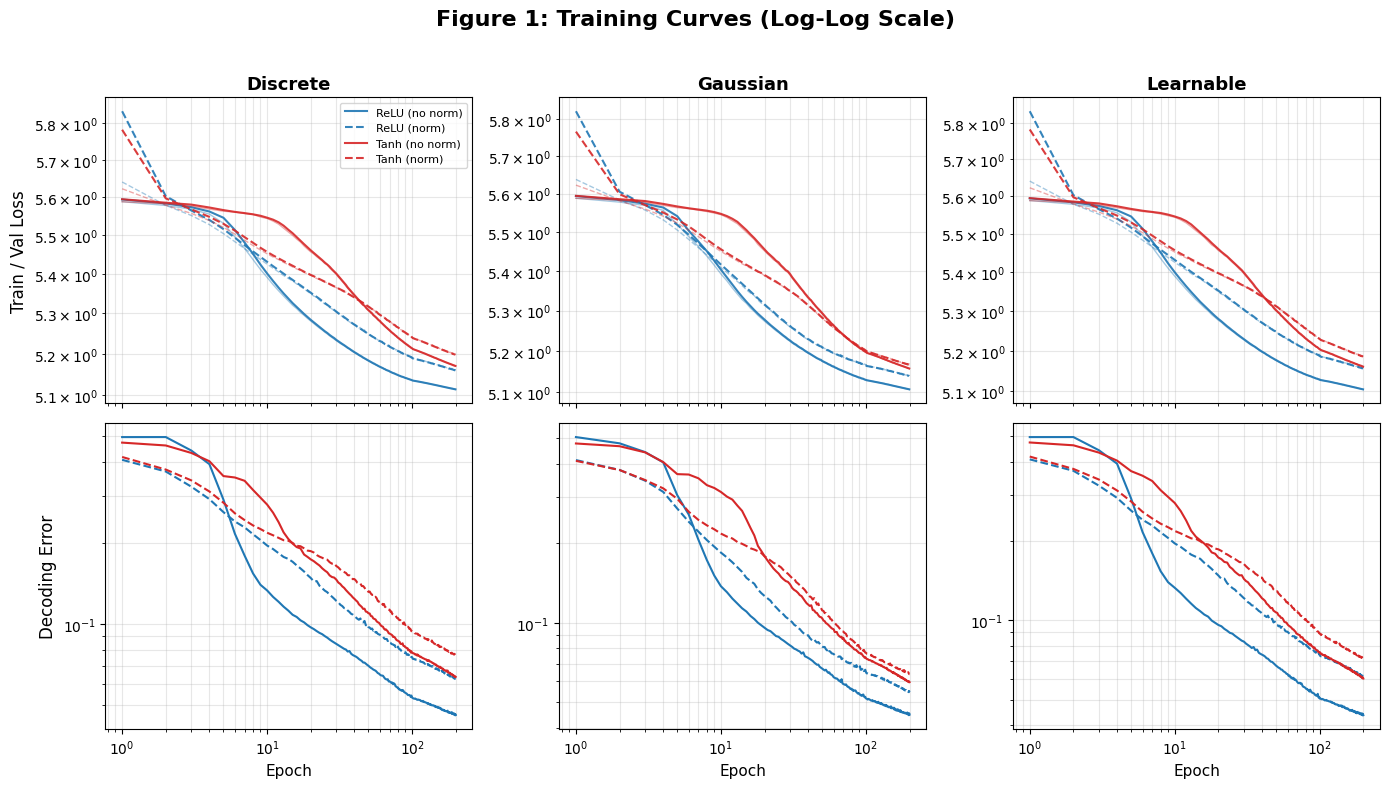

In [10]:
# 2 rows × 3 columns
# Row 1: Train/Val Loss, Row 2: Decoding Error
# Columns: Discrete, Gaussian, Learnable
# Each panel overlays 4 model variants

col_labels = ["Discrete", "Gaussian", "Learnable"]
col_suffixes = ["discrete", "gaussian", "learnable"]

# 4 model variants with colors and linestyles
model_variants = [
    ("ReLU_nonorm", "ReLU (no norm)", "tab:blue", "-"),
    ("ReLU_norm", "ReLU (norm)", "tab:blue", "--"),
    ("Tanh_nonorm", "Tanh (no norm)", "tab:red", "-"),
    ("Tanh_norm", "Tanh (norm)", "tab:red", "--"),
]

# Also define model_grid for later use (Figure 2)
row_labels = ["ReLU (no norm)", "ReLU (norm)", "Tanh (no norm)", "Tanh (norm)"]
model_grid = [
    ["ReLU_nonorm_discrete", "ReLU_nonorm_gaussian", "ReLU_nonorm_learnable"],
    ["ReLU_norm_discrete", "ReLU_norm_gaussian", "ReLU_norm_learnable"],
    ["Tanh_nonorm_discrete", "Tanh_nonorm_gaussian", "Tanh_nonorm_learnable"],
    ["Tanh_norm_discrete", "Tanh_norm_gaussian", "Tanh_norm_learnable"],
]

fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True)

for j, (col_label, suffix) in enumerate(zip(col_labels, col_suffixes)):
    ax_loss = axes[0, j]
    ax_dec = axes[1, j]
    
    for prefix, label, color, ls in model_variants:
        model_name = f"{prefix}_{suffix}"
        data = all_training_data[model_name]
        
        epochs_train = np.arange(1, len(data["train_loss"]) + 1)
        epochs_val = np.arange(1, len(data["val_loss"]) + 1)
        epochs_dec = np.arange(1, len(data["decoding_error"]) + 1)
        
        # Row 1: Train (solid) and Val (same style, slightly transparent)
        ax_loss.loglog(epochs_train, data["train_loss"], color=color, linestyle=ls, 
                       linewidth=1.5, label=f"{label}", alpha=0.9)
        ax_loss.loglog(epochs_val, data["val_loss"], color=color, linestyle=ls, 
                       linewidth=1.0, alpha=0.4)  # Val loss fainter
        
        # Row 2: Decoding error
        ax_dec.loglog(epochs_dec, data["decoding_error"], color=color, linestyle=ls,
                      linewidth=1.5, label=label)
    
    # Column titles
    ax_loss.set_title(col_label, fontsize=13, fontweight="bold")
    ax_loss.grid(True, alpha=0.3, which="both")
    ax_dec.grid(True, alpha=0.3, which="both")
    ax_dec.set_xlabel("Epoch", fontsize=11)

# Row labels
axes[0, 0].set_ylabel("Train / Val Loss", fontsize=12)
axes[1, 0].set_ylabel("Decoding Error", fontsize=12)

# Legend (top-left panel only)
axes[0, 0].legend(loc="upper right", fontsize=8)

fig.suptitle("Figure 1: Training Curves (Log-Log Scale)", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

---

## Figure 2: Hidden State Magnitude Dynamics

12 panels showing ||h_t||, ||leak||, ||drive|| over time


In [11]:
def compute_dynamics_decomposition(model, inputs, initial_hidden):
    """
    Run model and decompose into leak and drive terms.
    
    Returns:
        hidden_states: (batch, time, hidden_size)
        leak_terms: (batch, time, hidden_size)
        drive_terms: (batch, time, hidden_size)
    """
    batch_size, num_steps, _ = inputs.shape
    hidden_size = model.hidden_size
    
    hidden_states = torch.zeros(batch_size, num_steps, hidden_size)
    leak_terms = torch.zeros(batch_size, num_steps, hidden_size)
    drive_terms = torch.zeros(batch_size, num_steps, hidden_size)
    
    hidden = initial_hidden
    alphas = model.rnn_step.current_alphas
    
    with torch.no_grad():
        for t in range(num_steps):
            hidden_states[:, t] = hidden
            
            leak = (1 - alphas) * hidden
            leak_terms[:, t] = leak
            
            pre_activation = model.rnn_step.W_in(inputs[:, t]) + model.rnn_step.W_rec(hidden)
            activated = model.rnn_step.activation(pre_activation)
            drive = alphas * activated
            drive_terms[:, t] = drive
            
            hidden = leak + drive
            
            # Apply normalization if model has it
            if hasattr(model.rnn_step, 'layer_norm') and model.rnn_step.layer_norm is not None:
                hidden = model.rnn_step.layer_norm(hidden)
    
    return hidden_states, leak_terms, drive_terms

In [12]:
# Load one model to get config for data generation
ref_model, ref_config, ref_pcc = load_model(SWEEP_DIR / "ReLU_nonorm_discrete" / "seed_0")

# Create datamodule for trajectory generation
NUM_TIMESTEPS_EVAL = 20
NUM_TRAJECTORIES = 50

datamodule = PathIntegrationDataModule(
    trajectory_type=ref_config["trajectory_type"],
    velocity_representation=ref_config["velocity_representation"],
    dt=ref_config["dt"],
    num_time_steps=NUM_TIMESTEPS_EVAL,
    arena_size=ref_config["arena_size"],
    num_place_cells=ref_config["num_place_cells"],
    place_cell_rf=ref_config["place_cell_rf"],
    DoG=ref_config["DoG"],
    surround_scale=ref_config["surround_scale"],
    place_cell_layout=ref_config["place_cell_layout"],
    behavioral_timescale_mean=ref_config.get("behavioral_timescale_mean", 1.0),
    behavioral_timescale_std=ref_config.get("behavioral_timescale_std", 0.2),
    linear_speed_tau=ref_config.get("linear_speed_tau", 1.0),
    angular_speed_mean=ref_config.get("angular_speed_mean", 0.0),
    angular_speed_std=ref_config.get("angular_speed_std", 1.0),
    angular_speed_tau=ref_config.get("angular_speed_tau", 0.4),
    num_trajectories=NUM_TRAJECTORIES,
    batch_size=NUM_TRAJECTORIES,
    num_workers=4,
    train_val_split=0.0,
)
datamodule.place_cell_centers = ref_pcc
datamodule.setup()

batch = next(iter(datamodule.val_dataloader()))
inputs, positions, place_cells = batch

time_axis = np.arange(NUM_TIMESTEPS_EVAL) * ref_config["dt"]

print(f"Test trajectories: {inputs.shape}")
print(f"Time range: 0 to {time_axis[-1]:.1f}s")

Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Test trajectories: torch.Size([50, 20, 2])
Time range: 0 to 1.9s


In [13]:
# Compute dynamics for all models
all_dynamics = {}

for name in MODEL_NAMES:
    model_dir = SWEEP_DIR / name / "seed_0"
    model, config, pcc = load_model(model_dir)
    
    # Compute initial hidden state
    initial_hidden = model.W_h_init(place_cells[:, 0, :])
    
    # Run dynamics decomposition
    hidden_states, leak_terms, drive_terms = compute_dynamics_decomposition(
        model, inputs, initial_hidden
    )
    
    # Compute L2 norms and mean/std absolute values across neurons
    all_dynamics[name] = {
        # L2 norms
        "hidden_norm": torch.norm(hidden_states, dim=2).numpy(),
        "leak_norm": torch.norm(leak_terms, dim=2).numpy(),
        "drive_norm": torch.norm(drive_terms, dim=2).numpy(),
        # Mean absolute values across neurons: shape (batch, time)
        "hidden_mean_abs": torch.abs(hidden_states).mean(dim=2).numpy(),
        "leak_mean_abs": torch.abs(leak_terms).mean(dim=2).numpy(),
        "drive_mean_abs": torch.abs(drive_terms).mean(dim=2).numpy(),
        # Std absolute values across neurons: shape (batch, time)
        "hidden_std_abs": torch.abs(hidden_states).std(dim=2).numpy(),
    }
    
print(f"Computed dynamics for {len(all_dynamics)} models")

Timescales are LEARNABLE (uniform init at τ=0.5s)
Timescales are LEARNABLE (uniform init at τ=0.5s)


Timescales are LEARNABLE (uniform init at τ=0.5s)
Timescales are LEARNABLE (uniform init at τ=0.5s)
Computed dynamics for 12 models


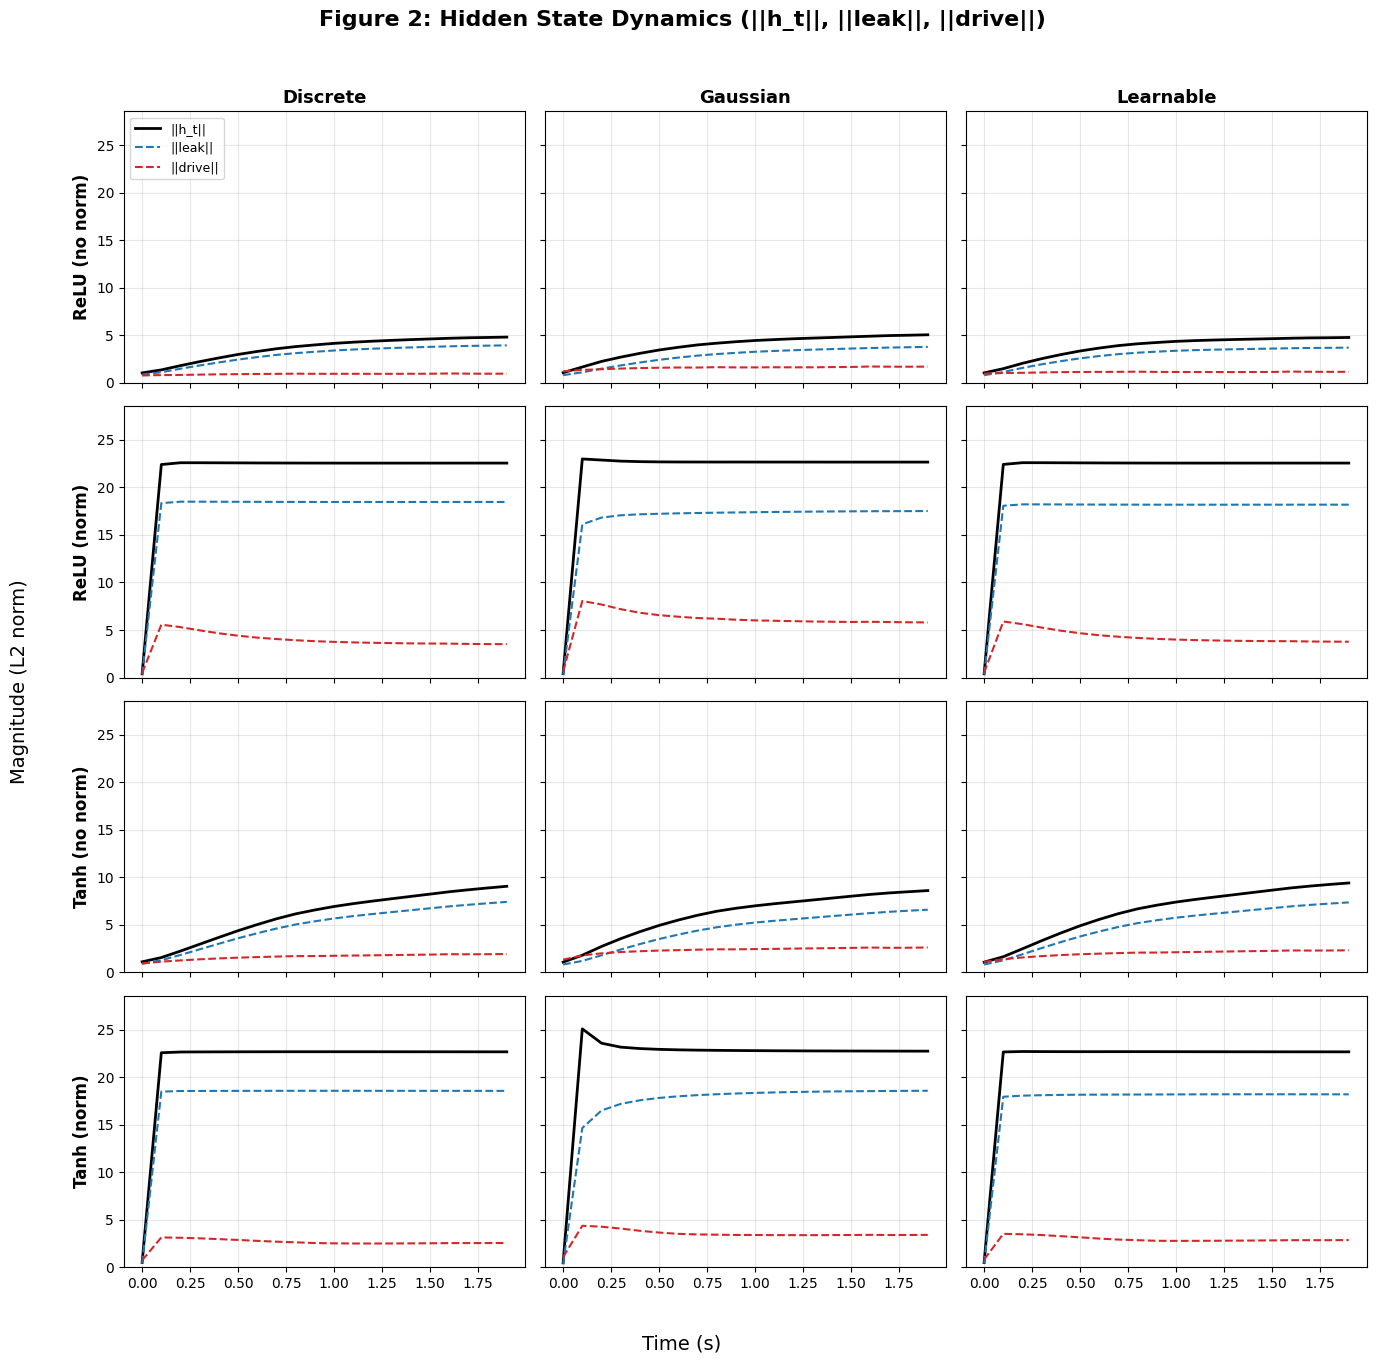

In [14]:
# Determine shared y-axis limits
all_hidden_max = max(d["hidden_norm"].max() for d in all_dynamics.values())
all_leak_max = max(d["leak_norm"].max() for d in all_dynamics.values())
all_drive_max = max(d["drive_norm"].max() for d in all_dynamics.values())
y_max = max(all_hidden_max, all_leak_max, all_drive_max) * 1.1

fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=True, sharey=True)

for i, row in enumerate(model_grid):
    for j, model_name in enumerate(row):
        ax = axes[i, j]
        data = all_dynamics[model_name]
        
        # Mean across trajectories
        hidden_mean = data["hidden_norm"].mean(axis=0)
        leak_mean = data["leak_norm"].mean(axis=0)
        drive_mean = data["drive_norm"].mean(axis=0)
        
        ax.plot(time_axis, hidden_mean, label="||h_t||", color="black", linewidth=2)
        ax.plot(time_axis, leak_mean, label="||leak||", color="tab:blue", linewidth=1.5, linestyle="--")
        ax.plot(time_axis, drive_mean, label="||drive||", color="tab:red", linewidth=1.5, linestyle="--")
        
        ax.set_ylim(0, y_max)
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.set_title(col_labels[j], fontsize=13, fontweight="bold")
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=12, fontweight="bold")
        if i == 0 and j == 0:
            ax.legend(loc="upper left", fontsize=9)

fig.supxlabel("Time (s)", fontsize=14, y=0.02)
fig.supylabel("Magnitude (L2 norm)", fontsize=14, x=0.02)
fig.suptitle("Figure 2: Hidden State Dynamics (||h_t||, ||leak||, ||drive||)", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()

---

## Figure 2b: Mean Absolute Neuron Activity

Same as Figure 2, but showing mean(|h_i|) instead of ||h_t||

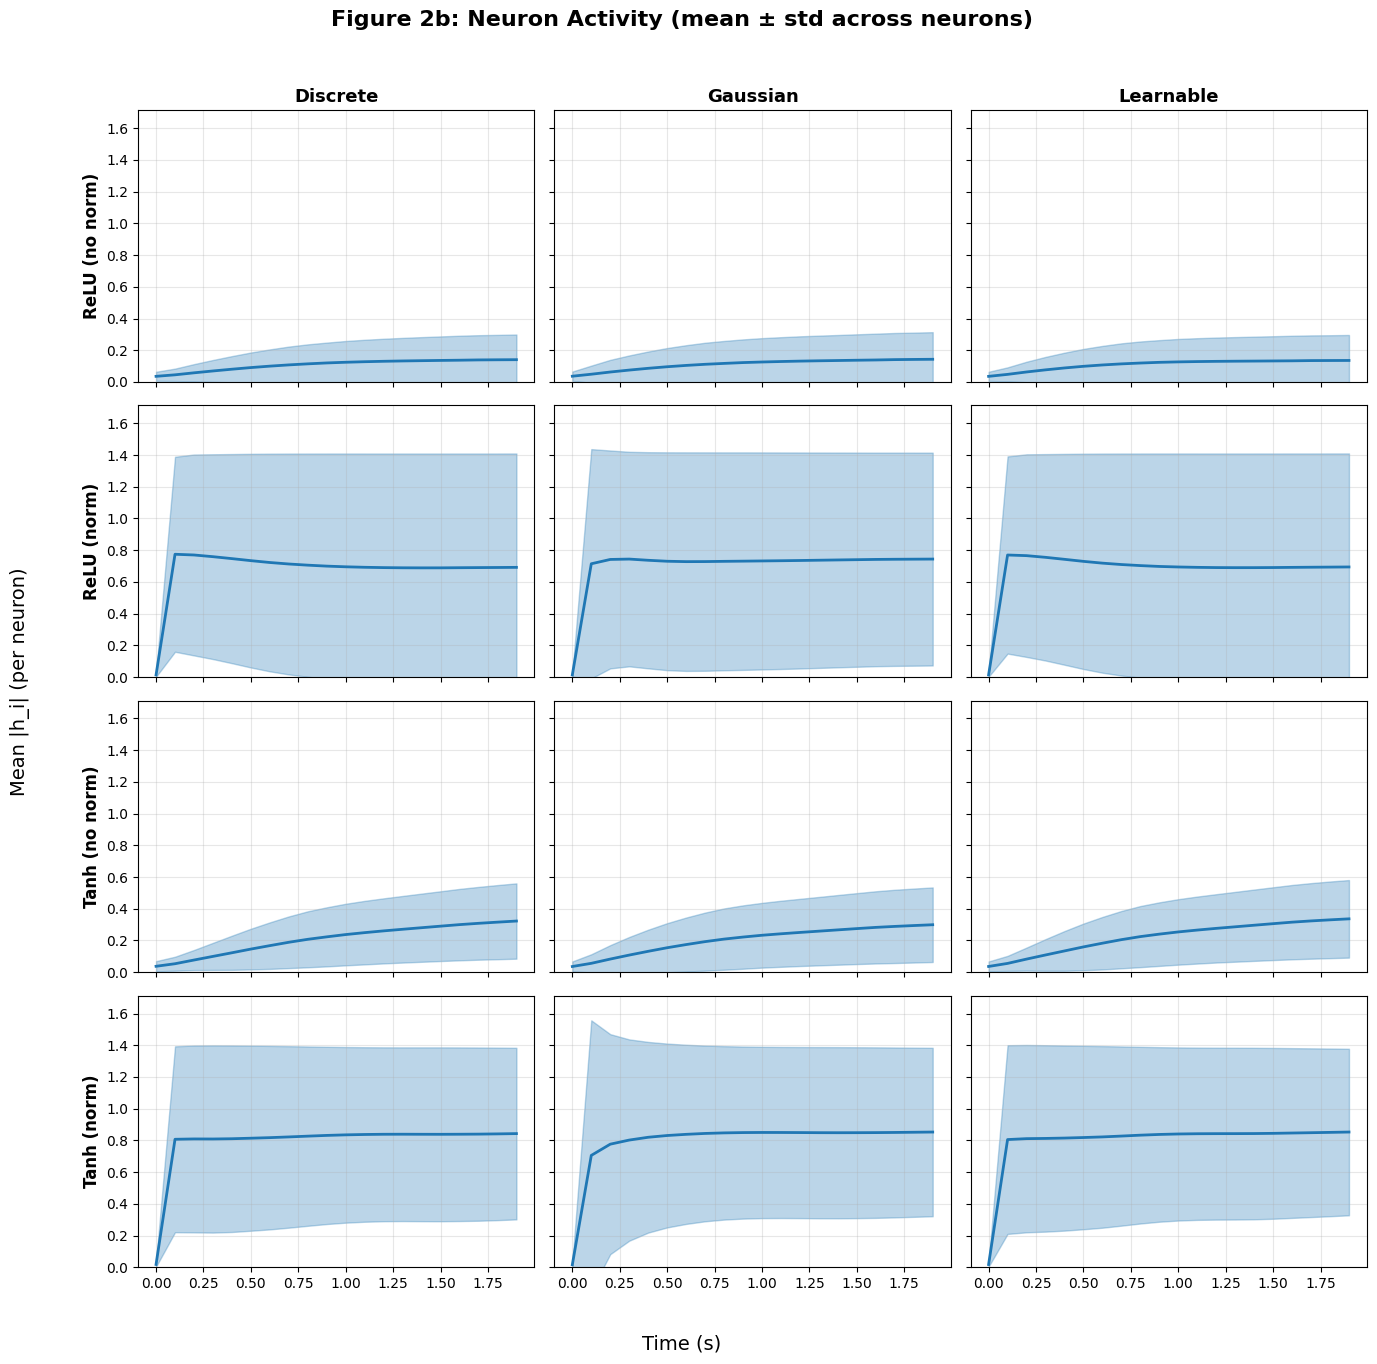

In [15]:
# Determine shared y-axis limits for mean absolute values (with neuron std headroom)
all_hidden_abs_max = max(
    (d["hidden_mean_abs"].mean(axis=0) + d["hidden_std_abs"].mean(axis=0)).max() 
    for d in all_dynamics.values()
)
y_max_abs = all_hidden_abs_max * 1.1

fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=True, sharey=True)

for i, row in enumerate(model_grid):
    for j, model_name in enumerate(row):
        ax = axes[i, j]
        data = all_dynamics[model_name]
        
        # Mean across trajectories of: mean across neurons, std across neurons
        hidden_mean = data["hidden_mean_abs"].mean(axis=0)  # avg over trajectories
        hidden_std = data["hidden_std_abs"].mean(axis=0)    # avg neuron-std over trajectories
        
        # Shaded area for variability across neurons
        ax.fill_between(time_axis, hidden_mean - hidden_std, hidden_mean + hidden_std,
                        alpha=0.3, color="tab:blue")
        ax.plot(time_axis, hidden_mean, color="tab:blue", linewidth=2)
        
        ax.set_ylim(0, y_max_abs)
        ax.grid(True, alpha=0.3)
        
        if i == 0:
            ax.set_title(col_labels[j], fontsize=13, fontweight="bold")
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=12, fontweight="bold")

fig.supxlabel("Time (s)", fontsize=14, y=0.02)
fig.supylabel("Mean |h_i| (per neuron)", fontsize=14, x=0.02)
fig.suptitle("Figure 2b: Neuron Activity (mean ± std across neurons)", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()

---

## Figure 3: Learned Timescale Distributions

For learnable models only (4 models): histogram of learned timescales vs behavioral timescale distribution


In [16]:
# Learnable models
learnable_models = [
    "ReLU_nonorm_learnable",
    "ReLU_norm_learnable",
    "Tanh_nonorm_learnable",
    "Tanh_norm_learnable",
]

learnable_labels = [
    "ReLU (no norm)",
    "ReLU (norm)",
    "Tanh (no norm)",
    "Tanh (norm)",
]

# Get behavioral timescale distribution from config
behav_mean = ref_config.get("behavioral_timescale_mean", 1.0)
behav_std = ref_config.get("behavioral_timescale_std", 0.2)

# Generate behavioral timescale samples for comparison
np.random.seed(42)
behav_timescales = np.random.normal(behav_mean, behav_std, 10000)
behav_timescales = np.clip(behav_timescales, 0.01, None)  # Clip to positive

print(f"Behavioral timescale: μ={behav_mean}, σ={behav_std}")

Behavioral timescale: μ=1.0, σ=0.2


In [17]:
# Load learned timescales for each learnable model
learned_timescales = {}

for name in learnable_models:
    model_dir = SWEEP_DIR / name / "seed_0"
    model, config, _ = load_model(model_dir)
    
    # Get final learned timescales
    ts = model.rnn_step.current_timescales.detach().cpu().numpy()
    learned_timescales[name] = ts
    
    print(f"{name}: mean={ts.mean():.3f}, std={ts.std():.3f}, min={ts.min():.3f}, max={ts.max():.3f}")

Timescales are LEARNABLE (uniform init at τ=0.5s)
ReLU_nonorm_learnable: mean=0.399, std=0.049, min=0.277, max=0.609
Timescales are LEARNABLE (uniform init at τ=0.5s)
ReLU_norm_learnable: mean=0.477, std=0.020, min=0.358, max=0.507
Timescales are LEARNABLE (uniform init at τ=0.5s)
Tanh_nonorm_learnable: mean=0.426, std=0.051, min=0.268, max=0.496
Timescales are LEARNABLE (uniform init at τ=0.5s)
Tanh_norm_learnable: mean=0.444, std=0.041, min=0.270, max=0.499


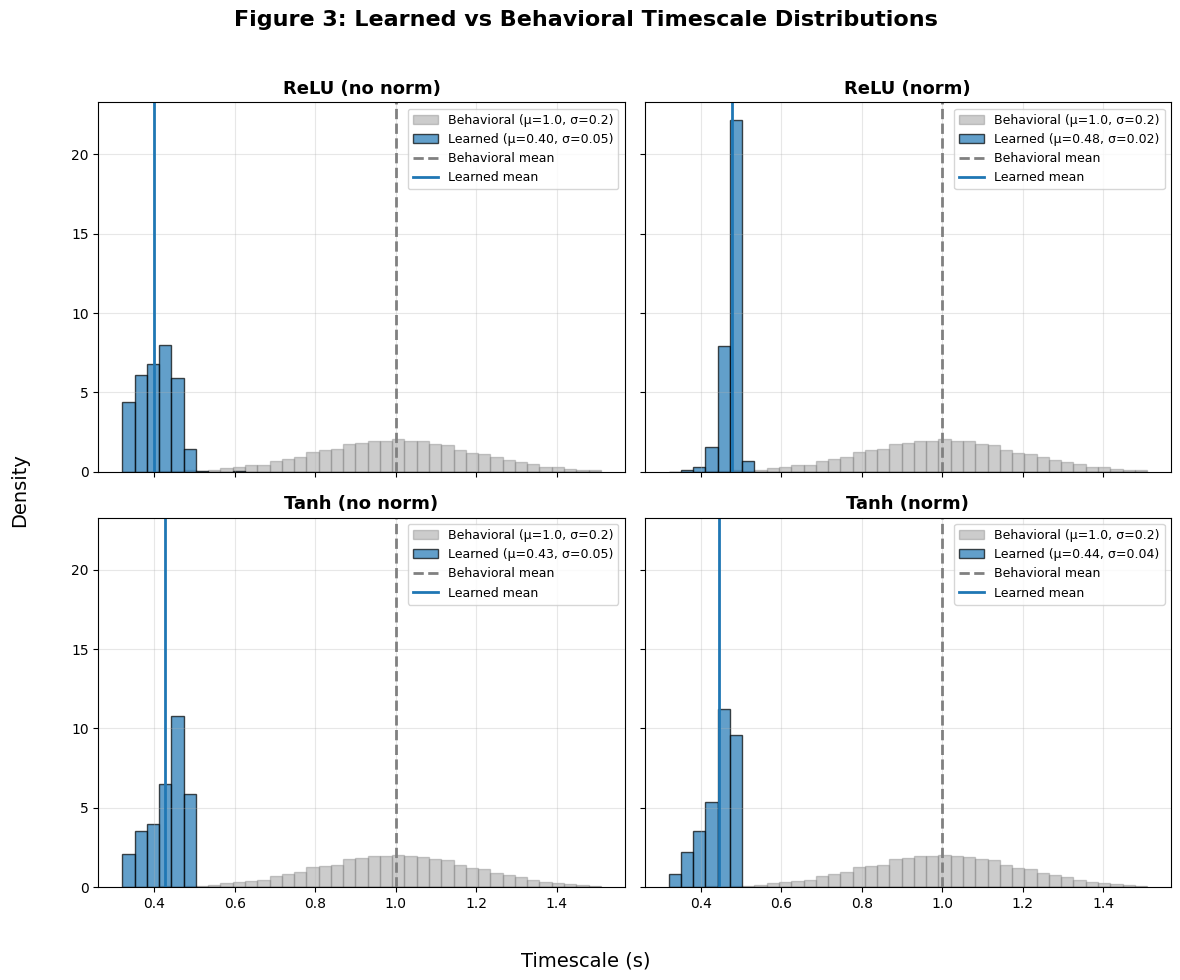

In [18]:
# Determine shared x-axis limits
all_ts = np.concatenate([behav_timescales] + list(learned_timescales.values()))
x_min, x_max = np.percentile(all_ts, [0.5, 99.5])
bins = np.linspace(x_min, x_max, 40)

fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axes = axes.flatten()

for idx, (name, label) in enumerate(zip(learnable_models, learnable_labels)):
    ax = axes[idx]
    ts = learned_timescales[name]
    
    # Behavioral distribution
    ax.hist(behav_timescales, bins=bins, alpha=0.4, color="gray", 
            label=f"Behavioral (μ={behav_mean}, σ={behav_std})", density=True, edgecolor="gray")
    
    # Learned distribution
    ax.hist(ts, bins=bins, alpha=0.7, color="tab:blue",
            label=f"Learned (μ={ts.mean():.2f}, σ={ts.std():.2f})", density=True, edgecolor="black")
    
    # Vertical lines for means
    ax.axvline(behav_mean, color="gray", linestyle="--", linewidth=2, label=f"Behavioral mean")
    ax.axvline(ts.mean(), color="tab:blue", linestyle="-", linewidth=2, label=f"Learned mean")
    
    ax.set_title(label, fontsize=13, fontweight="bold")
    ax.legend(loc="upper right", fontsize=9)
    ax.grid(True, alpha=0.3)

fig.supxlabel("Timescale (s)", fontsize=14, y=0.02)
fig.supylabel("Density", fontsize=14, x=0.02)
fig.suptitle("Figure 3: Learned vs Behavioral Timescale Distributions", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()

---

## Figure 4: Top 3 Eigenvalues of W_rec

Compute and visualize the top 3 eigenvalues (by magnitude) of the recurrent weight matrix W_rec for each model.


In [ ]:
# Compute top 3 eigenvalues of W_rec for each model
all_eigenvalues = {}

for name in MODEL_NAMES:
    model_dir = SWEEP_DIR / name / "seed_0"
    model, config, _ = load_model(model_dir)
    
    # Get W_rec weight matrix: (hidden_size, hidden_size)
    W_rec = model.rnn_step.W_rec.weight.data  # Shape: (hidden_size, hidden_size)
    
    # Compute eigenvalues (complex-valued in general)
    eigenvals = torch.linalg.eigvals(W_rec)
    
    # Get magnitude of eigenvalues
    eigenvals_mag = torch.abs(eigenvals)
    
    # Sort by magnitude and get top 3
    top3_idx = torch.argsort(eigenvals_mag, descending=True)[:3]
    top3_eigenvals = eigenvals[top3_idx]
    top3_mag = eigenvals_mag[top3_idx]
    
    # Store real and imaginary parts, and magnitude
    all_eigenvalues[name] = {
        "real": top3_eigenvals.real.cpu().numpy(),
        "imag": top3_eigenvals.imag.cpu().numpy(),
        "magnitude": top3_mag.cpu().numpy(),
    }
    
    print(f"{name}: top 3 eigenvalues (magnitude) = {top3_mag.cpu().numpy()}")

print(f"\n✓ Computed eigenvalues for {len(all_eigenvalues)} models")

In [ ]:
# Figure 4: Top 3 Eigenvalues of W_rec
# 4 rows × 3 columns grid (same layout as Figure 2)
fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=True, sharey=True)

# Use same model_grid layout as Figure 2
for i, row in enumerate(model_grid):
    for j, model_name in enumerate(row):
        ax = axes[i, j]
        evals = all_eigenvalues[model_name]
        
        # Plot eigenvalues in complex plane (real vs imaginary)
        # Top 3 eigenvalues as different markers
        colors = ["tab:blue", "tab:orange", "tab:green"]
        markers = ["o", "s", "D"]
        
        for k in range(3):
            ax.scatter(
                evals["real"][k],
                evals["imag"][k],
                s=100,
                color=colors[k],
                marker=markers[k],
                alpha=0.7,
                edgecolors="black",
                linewidths=1.5,
                label=f"λ{k+1}" if i == 0 and j == 0 else "",
            )
        
        # Add unit circle for reference (eigenvalues inside unit circle = stable)
        theta = np.linspace(0, 2 * np.pi, 100)
        ax.plot(np.cos(theta), np.sin(theta), "k--", alpha=0.3, linewidth=1, label="|λ|=1" if i == 0 and j == 0 else "")
        
        # Add axes
        ax.axhline(y=0, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
        ax.axvline(x=0, color="gray", linestyle="-", alpha=0.3, linewidth=0.5)
        
        ax.grid(True, alpha=0.3)
        ax.set_aspect("equal", adjustable="box")
        
        # Set reasonable limits (most eigenvalues should be within unit circle or slightly outside)
        ax.set_xlim(-1.5, 1.5)
        ax.set_ylim(-1.5, 1.5)
        
        if i == 0:
            ax.set_title(col_labels[j], fontsize=13, fontweight="bold")
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=12, fontweight="bold")
        if i == 0 and j == 0:
            ax.legend(loc="upper right", fontsize=9)

fig.supxlabel("Real(λ)", fontsize=14, y=0.02)
fig.supylabel("Imag(λ)", fontsize=14, x=0.02)
fig.suptitle("Figure 4: Top 3 Eigenvalues of W_rec (Complex Plane)", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()

# Also create a bar plot showing magnitudes
fig, axes = plt.subplots(4, 3, figsize=(14, 14), sharex=True, sharey=True)

for i, row in enumerate(model_grid):
    for j, model_name in enumerate(row):
        ax = axes[i, j]
        evals = all_eigenvalues[model_name]
        
        # Bar plot of magnitudes
        x_pos = np.arange(3)
        colors = ["tab:blue", "tab:orange", "tab:green"]
        
        bars = ax.bar(x_pos, evals["magnitude"], color=colors, alpha=0.7, edgecolor="black", linewidth=1.5)
        
        # Add value labels on bars
        for k, (bar, mag) in enumerate(zip(bars, evals["magnitude"])):
            height = bar.get_height()
            ax.text(
                bar.get_x() + bar.get_width() / 2.0,
                height,
                f"{mag:.2f}",
                ha="center",
                va="bottom",
                fontsize=9,
            )
        
        # Add unit circle reference line
        ax.axhline(y=1.0, color="red", linestyle="--", alpha=0.5, linewidth=1.5, label="|λ|=1" if i == 0 and j == 0 else "")
        
        ax.set_xticks(x_pos)
        ax.set_xticklabels([f"λ{k+1}" for k in range(3)])
        ax.set_ylim(0, max(1.5, evals["magnitude"].max() * 1.2))
        ax.grid(True, alpha=0.3, axis="y")
        
        if i == 0:
            ax.set_title(col_labels[j], fontsize=13, fontweight="bold")
        if j == 0:
            ax.set_ylabel(row_labels[i], fontsize=12, fontweight="bold")
        if i == 0 and j == 0:
            ax.legend(loc="upper right", fontsize=9)

fig.supxlabel("Eigenvalue Index", fontsize=14, y=0.02)
fig.supylabel("|λ| (Magnitude)", fontsize=14, x=0.02)
fig.suptitle("Figure 4b: Top 3 Eigenvalue Magnitudes of W_rec", fontsize=16, fontweight="bold", y=0.98)

plt.tight_layout(rect=[0.03, 0.03, 1, 0.96])
plt.show()


---

## Figure 5: OOD Generalization

Test model generalization under distribution shift:
- **5a**: Trajectory Length (training = 50 steps)
- **5b**: Behavioral Timescale Mean (training = 1.0s)
- **5c**: Behavioral Timescale Std (training = 0.2s)


In [19]:
from analysis.measurements import PositionDecodingMeasurement

measurement = PositionDecodingMeasurement(decode_k=3)


def evaluate_ood_length(model, config, place_cell_centers, test_lengths, num_trajectories=100):
    """Evaluate model on different trajectory lengths."""
    errors = []
    
    for length in test_lengths:
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=length,
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
            behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=num_trajectories,
            num_workers=4,
            train_val_split=0.0,
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()
        
        error = measurement.compute(model, datamodule)
        errors.append(error)
    
    return np.array(errors)


def evaluate_ood_behav_mean(model, config, place_cell_centers, test_means, num_trajectories=100):
    """Evaluate model with different behavioral timescale means."""
    errors = []
    
    for behav_mean in test_means:
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=config["num_time_steps"],
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            behavioral_timescale_mean=behav_mean,
            behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=num_trajectories,
            num_workers=4,
            train_val_split=0.0,
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()
        
        error = measurement.compute(model, datamodule)
        errors.append(error)
    
    return np.array(errors)


def evaluate_ood_behav_std(model, config, place_cell_centers, test_stds, num_trajectories=100):
    """Evaluate model with different behavioral timescale stds."""
    errors = []
    
    for behav_std in test_stds:
        datamodule = PathIntegrationDataModule(
            trajectory_type=config["trajectory_type"],
            velocity_representation=config["velocity_representation"],
            dt=config["dt"],
            num_time_steps=config["num_time_steps"],
            arena_size=config["arena_size"],
            num_place_cells=config["num_place_cells"],
            place_cell_rf=config["place_cell_rf"],
            DoG=config["DoG"],
            surround_scale=config["surround_scale"],
            place_cell_layout=config["place_cell_layout"],
            behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
            behavioral_timescale_std=behav_std,
            linear_speed_tau=config.get("linear_speed_tau", 1.0),
            angular_speed_mean=config.get("angular_speed_mean", 0.0),
            angular_speed_std=config.get("angular_speed_std", 1.0),
            angular_speed_tau=config.get("angular_speed_tau", 0.4),
            num_trajectories=num_trajectories,
            batch_size=num_trajectories,
            num_workers=4,
            train_val_split=0.0,
        )
        datamodule.place_cell_centers = place_cell_centers
        datamodule.setup()
        
        error = measurement.compute(model, datamodule)
        errors.append(error)
    
    return np.array(errors)

print("OOD evaluation functions defined")

OOD evaluation functions defined


In [21]:
# OOD test conditions
test_lengths = [10, 20, 50, 100, 150, 200]
test_behav_means = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0]
test_behav_stds = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7]

# Training conditions (for reference lines)
training_length = ref_config["num_time_steps"]
training_behav_mean = ref_config.get("behavioral_timescale_mean", 1.0)
training_behav_std = ref_config.get("behavioral_timescale_std", 0.2)

print(f"Training conditions:")
print(f"  Trajectory length: {training_length} steps")
print(f"  Behavioral timescale mean: {training_behav_mean}s")
print(f"  Behavioral timescale std: {training_behav_std}s")

# Run OOD evaluation for all models
all_ood_results = {}

for name in MODEL_NAMES:
    print(f"\nEvaluating {name}...")
    model_dir = SWEEP_DIR / name / "seed_0"
    model, config, pcc = load_model(model_dir)
    
    all_ood_results[name] = {
        "length": evaluate_ood_length(model, config, pcc, test_lengths),
        "behav_mean": evaluate_ood_behav_mean(model, config, pcc, test_behav_means),
        "behav_std": evaluate_ood_behav_std(model, config, pcc, test_behav_stds),
    }

print("\n✓ OOD evaluation complete")

Training conditions:
  Trajectory length: 50 steps
  Behavioral timescale mean: 1.0s
  Behavioral timescale std: 0.2s

Evaluating ReLU_nonorm_discrete...
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s


KeyboardInterrupt: 

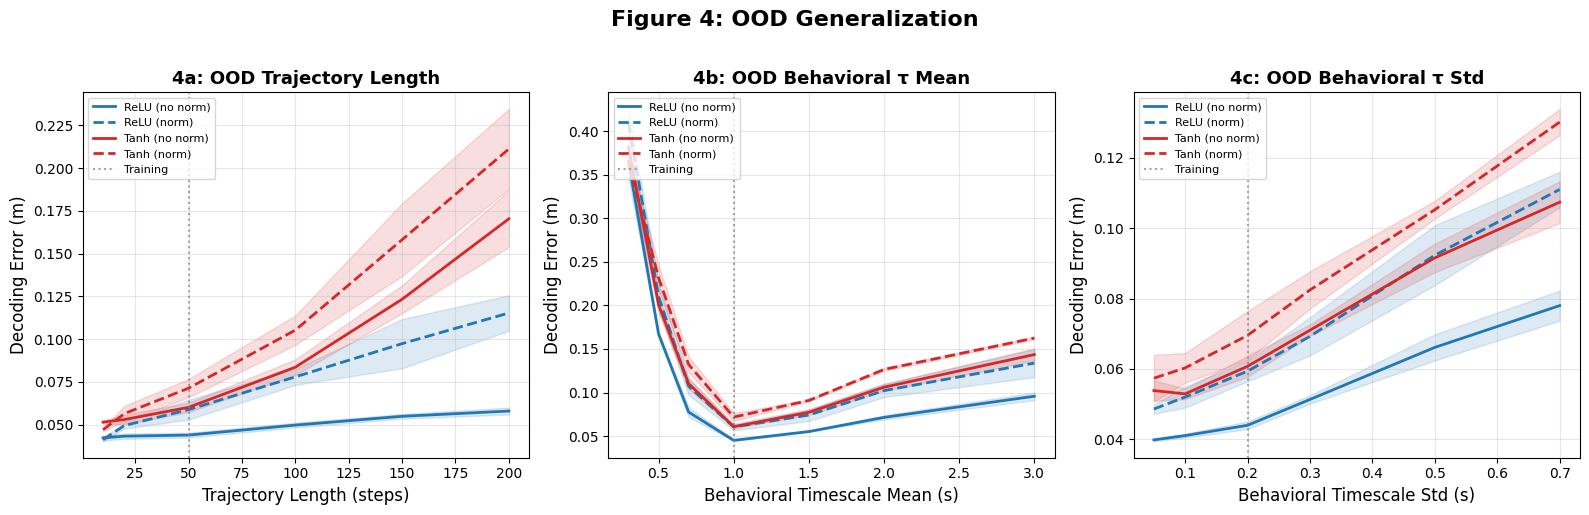

In [ ]:
# Figure 5: OOD Generalization (3 subplots)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Colors and linestyles for model variants (same as Figure 1)
model_variants = [
    ("ReLU_nonorm", "ReLU (no norm)", "tab:blue", "-"),
    ("ReLU_norm", "ReLU (norm)", "tab:blue", "--"),
    ("Tanh_nonorm", "Tanh (no norm)", "tab:red", "-"),
    ("Tanh_norm", "Tanh (norm)", "tab:red", "--"),
]

# We'll plot one curve per model variant, averaging across timescale types (discrete, gaussian, learnable)
col_suffixes = ["discrete", "gaussian", "learnable"]

# --- 4a: Trajectory Length ---
ax = axes[0]
for prefix, label, color, ls in model_variants:
    # Average across timescale types
    errors_all = [all_ood_results[f"{prefix}_{suffix}"]["length"] for suffix in col_suffixes]
    errors_mean = np.mean(errors_all, axis=0)
    errors_std = np.std(errors_all, axis=0)
    
    ax.fill_between(test_lengths, errors_mean - errors_std, errors_mean + errors_std, 
                    alpha=0.15, color=color)
    ax.plot(test_lengths, errors_mean, label=label, color=color, linestyle=ls, linewidth=2)

ax.axvline(training_length, color="gray", linestyle=":", linewidth=1.5, alpha=0.7, label="Training")
ax.set_xlabel("Trajectory Length (steps)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("5a: OOD Trajectory Length", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- 4b: Behavioral Timescale Mean ---
ax = axes[1]
for prefix, label, color, ls in model_variants:
    errors_all = [all_ood_results[f"{prefix}_{suffix}"]["behav_mean"] for suffix in col_suffixes]
    errors_mean = np.mean(errors_all, axis=0)
    errors_std = np.std(errors_all, axis=0)
    
    ax.fill_between(test_behav_means, errors_mean - errors_std, errors_mean + errors_std, 
                    alpha=0.15, color=color)
    ax.plot(test_behav_means, errors_mean, label=label, color=color, linestyle=ls, linewidth=2)

ax.axvline(training_behav_mean, color="gray", linestyle=":", linewidth=1.5, alpha=0.7, label="Training")
ax.set_xlabel("Behavioral Timescale Mean (s)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("5b: OOD Behavioral τ Mean", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

# --- 4c: Behavioral Timescale Std ---
ax = axes[2]
for prefix, label, color, ls in model_variants:
    errors_all = [all_ood_results[f"{prefix}_{suffix}"]["behav_std"] for suffix in col_suffixes]
    errors_mean = np.mean(errors_all, axis=0)
    errors_std = np.std(errors_all, axis=0)
    
    ax.fill_between(test_behav_stds, errors_mean - errors_std, errors_mean + errors_std, 
                    alpha=0.15, color=color)
    ax.plot(test_behav_stds, errors_mean, label=label, color=color, linestyle=ls, linewidth=2)

ax.axvline(training_behav_std, color="gray", linestyle=":", linewidth=1.5, alpha=0.7, label="Training")
ax.set_xlabel("Behavioral Timescale Std (s)", fontsize=12)
ax.set_ylabel("Decoding Error (m)", fontsize=12)
ax.set_title("5c: OOD Behavioral τ Std", fontsize=13, fontweight="bold")
ax.legend(loc="upper left", fontsize=8)
ax.grid(True, alpha=0.3)

fig.suptitle("Figure 5: OOD Generalization", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


### Grid Score Analysis

Compute average grid score for each model


In [ ]:
from analysis.spatial import SpatialAnalyzer

def compute_grid_score_stats(model, config, place_cell_centers, num_trajectories=2000, bin_size=0.05):
    """Compute grid scores for a model and return statistics."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()
    
    # Create eval datamodule
    eval_datamodule = PathIntegrationDataModule(
        trajectory_type=config["trajectory_type"],
        velocity_representation=config["velocity_representation"],
        dt=config["dt"],
        num_time_steps=config["num_time_steps"],
        arena_size=config["arena_size"],
        num_place_cells=config["num_place_cells"],
        place_cell_rf=config["place_cell_rf"],
        DoG=config["DoG"],
        surround_scale=config["surround_scale"],
        place_cell_layout=config["place_cell_layout"],
        behavioral_timescale_mean=config.get("behavioral_timescale_mean", 1.0),
        behavioral_timescale_std=config.get("behavioral_timescale_std", 0.2),
        linear_speed_tau=config.get("linear_speed_tau", 1.0),
        angular_speed_mean=config.get("angular_speed_mean", 0.0),
        angular_speed_std=config.get("angular_speed_std", 1.0),
        angular_speed_tau=config.get("angular_speed_tau", 0.4),
        num_trajectories=num_trajectories,
        batch_size=500,
        num_workers=4,
        train_val_split=0.0,
    )
    eval_datamodule.place_cell_centers = place_cell_centers
    eval_datamodule.setup()
    eval_loader = eval_datamodule.val_dataloader()
    
    # Compute spatial analysis
    spatial = SpatialAnalyzer(
        model=model,
        device=device,
        model_type="multitimescale",
    )
    
    spatial.compute_rate_maps(
        eval_loader=eval_loader,
        arena_size=config["arena_size"],
        bin_size=bin_size,
        num_trajectories=num_trajectories,
        min_occupancy=10,
        time_lag=0,
    )
    
    grid_results = spatial.compute_grid_scores(
        mask_parameters=[(0.4, 1.0), (0.5, 1.0), (0.6, 1.0)],
        min_max=False,
    )
    
    scores_60 = grid_results["scores_60"]
    scores_90 = grid_results["scores_90"]
    
    return {
        "mean_60": np.mean(scores_60),
        "std_60": np.std(scores_60),
        "mean_90": np.mean(scores_90),
        "std_90": np.std(scores_90),
        "pct_grid_cells_60": 100 * np.mean(scores_60 > 0.0),  # % with positive score
        "pct_grid_cells_90": 100 * np.mean(scores_90 > 0.0),
    }

print("Grid score function defined")

Grid score function defined


In [ ]:
# Compute grid scores for all models
all_grid_scores = {}

for name in MODEL_NAMES:
    print(f"\nComputing grid scores for {name}...")
    model_dir = SWEEP_DIR / name / "seed_0"
    model, config, pcc = load_model(model_dir)
    
    all_grid_scores[name] = compute_grid_score_stats(model, config, pcc)
    print(f"  Mean grid score (60°): {all_grid_scores[name]['mean_60']:.3f}")
    print(f"  % Grid cells (60°): {all_grid_scores[name]['pct_grid_cells_60']:.1f}%")

print("\n✓ Grid score computation complete")


Computing grid scores for ReLU_nonorm_discrete...
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 500/2000 trajectories...
Data collection complete. Total trajectories: 2000
Rate maps created. Bins with sufficient data: 484/484
Computing grid scores for 512 units...


/home/facosta/timescales/timescales/scores.py:130: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


  Processed 50/512 units...
  Processed 100/512 units...
  Processed 150/512 units...
  Processed 200/512 units...
  Processed 250/512 units...
  Processed 300/512 units...
  Processed 350/512 units...
  Processed 400/512 units...
  Processed 450/512 units...
  Processed 500/512 units...
Grid score computation complete!
  Mean 60° score: -0.113 ± 0.275
  Mean 90° score: 0.228 ± 0.610
  Max 60° score: 1.150
  Max 90° score: 1.658
  Mean grid score (60°): -0.113
  % Grid cells (60°): 27.1%

Computing grid scores for ReLU_nonorm_gaussian...
Behavioral timescale parameterization:
  τ_behavior: mean=1.000s, std=0.200s
  → linear_speed: mean=0.200m/s, std=0.040m/s
Computing concurrent spatial rate maps using 2000 trajectories...
Spatial grid: 22 x 22 bins of size 0.05
Hidden units to analyze: 512
Processed 500/2000 trajectories...
Data collection complete. Total trajectories: 2000
Rate maps created. Bins with sufficient data: 484/484
Computing grid scores for 512 units...
  Processed 50/512 

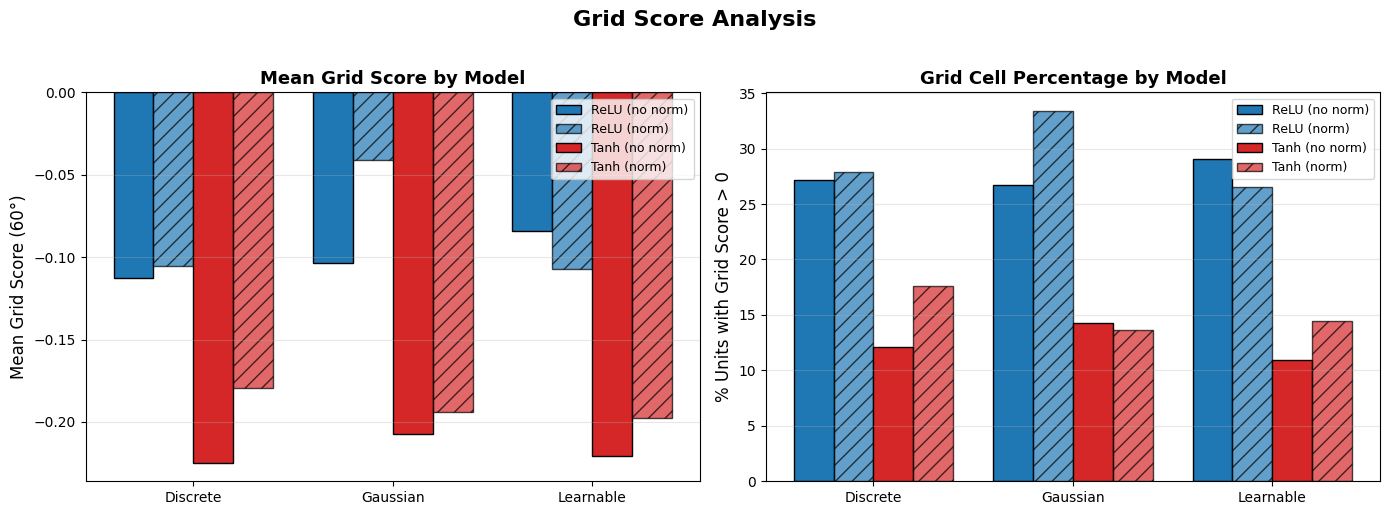


Model                            Mean GS (60°)    % Grid Cells
ReLU_nonorm_discrete                    -0.113           27.1%
ReLU_nonorm_gaussian                    -0.103           26.8%
ReLU_nonorm_learnable                   -0.084           29.1%
ReLU_norm_discrete                      -0.105           27.9%
ReLU_norm_gaussian                      -0.041           33.4%
ReLU_norm_learnable                     -0.107           26.6%
Tanh_nonorm_discrete                    -0.225           12.1%
Tanh_nonorm_gaussian                    -0.207           14.3%
Tanh_nonorm_learnable                   -0.221           10.9%
Tanh_norm_discrete                      -0.180           17.6%
Tanh_norm_gaussian                      -0.194           13.7%
Tanh_norm_learnable                     -0.198           14.5%


In [ ]:
# Visualize grid scores
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Organize data for plotting
model_labels = [
    "ReLU\n(no norm)", "ReLU\n(norm)", "Tanh\n(no norm)", "Tanh\n(norm)"
]
col_labels = ["Discrete", "Gaussian", "Learnable"]
colors = ["tab:blue", "tab:blue", "tab:red", "tab:red"]
hatches = ["", "//", "", "//"]

# Left: Mean grid score (60°) grouped by activation/norm
ax = axes[0]
x = np.arange(3)  # 3 timescale types
width = 0.2

for idx, (prefix, label, color, hatch) in enumerate(zip(
    ["ReLU_nonorm", "ReLU_norm", "Tanh_nonorm", "Tanh_norm"],
    model_labels,
    colors,
    hatches
)):
    means = [all_grid_scores[f"{prefix}_{suffix}"]["mean_60"] for suffix in ["discrete", "gaussian", "learnable"]]
    stds = [all_grid_scores[f"{prefix}_{suffix}"]["std_60"] for suffix in ["discrete", "gaussian", "learnable"]]
    ax.bar(x + idx * width, means, width, label=label.replace("\n", " "), 
           color=color, alpha=0.7 if hatch else 1.0, hatch=hatch, edgecolor="black")

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(col_labels)
ax.set_ylabel("Mean Grid Score (60°)", fontsize=12)
ax.set_title("Mean Grid Score by Model", fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.axhline(0, color="gray", linestyle=":", alpha=0.5)
ax.grid(True, alpha=0.3, axis="y")

# Right: Percentage of grid cells
ax = axes[1]
for idx, (prefix, label, color, hatch) in enumerate(zip(
    ["ReLU_nonorm", "ReLU_norm", "Tanh_nonorm", "Tanh_norm"],
    model_labels,
    colors,
    hatches
)):
    pcts = [all_grid_scores[f"{prefix}_{suffix}"]["pct_grid_cells_60"] for suffix in ["discrete", "gaussian", "learnable"]]
    ax.bar(x + idx * width, pcts, width, label=label.replace("\n", " "), 
           color=color, alpha=0.7 if hatch else 1.0, hatch=hatch, edgecolor="black")

ax.set_xticks(x + 1.5 * width)
ax.set_xticklabels(col_labels)
ax.set_ylabel("% Units with Grid Score > 0", fontsize=12)
ax.set_title("Grid Cell Percentage by Model", fontsize=13, fontweight="bold")
ax.legend(loc="upper right", fontsize=9)
ax.grid(True, alpha=0.3, axis="y")

fig.suptitle("Grid Score Analysis", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# Print summary table
print("\n" + "="*90)
print(f"{'Model':<30} {'Mean GS (60°)':>15} {'% Grid Cells':>15}")
print("="*90)
for name in MODEL_NAMES:
    gs = all_grid_scores[name]
    print(f"{name:<30} {gs['mean_60']:>15.3f} {gs['pct_grid_cells_60']:>14.1f}%")
print("="*90)

---

## Summary Statistics


In [ ]:
# Print summary table
print("="*90)
print(f"{'Model':<30} {'Final Train':>12} {'Final Val':>12} {'Final Dec Err':>14} {'||h_t|| ratio':>14}")
print("="*90)

for name in MODEL_NAMES:
    td = all_training_data[name]
    dd = all_dynamics[name]
    
    final_train = td["train_loss"][-1]
    final_val = td["val_loss"][-1]
    final_dec = td["decoding_error"][-1]
    
    h_ratio = dd["hidden_norm"].mean(axis=0)[-1] / dd["hidden_norm"].mean(axis=0)[0]
    
    print(f"{name:<30} {final_train:>12.4f} {final_val:>12.4f} {final_dec:>14.4f} {h_ratio:>14.2f}x")

print("="*90)

Model                           Final Train    Final Val  Final Dec Err  ||h_t|| ratio
ReLU_nonorm_discrete                 5.1131       5.1129         0.0460           4.48x
ReLU_nonorm_gaussian                 5.1071       5.1070         0.0448           4.64x
ReLU_nonorm_learnable                5.1048       5.1047         0.0437           4.47x
ReLU_norm_discrete                   5.1591       5.1599         0.0627          57.54x
ReLU_norm_gaussian                   5.1393       5.1394         0.0546          55.85x
ReLU_norm_learnable                  5.1561       5.1571         0.0616          57.79x
Tanh_nonorm_discrete                 5.1701       5.1697         0.0637           8.18x
Tanh_nonorm_gaussian                 5.1575       5.1571         0.0595           7.93x
Tanh_nonorm_learnable                5.1607       5.1602         0.0602           8.71x
Tanh_norm_discrete                   5.1975       5.1979         0.0766          44.67x
Tanh_norm_gaussian               